<a href="https://colab.research.google.com/github/honyango/test/blob/main/3_APACHE_MLIBSPARK_SELECTION_VISUALIZATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SET UP PYSPARK

In [1]:
# Install Java, Spark, and FindSpark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz -O spark-3.3.2-bin-hadoop3.tgz

# Verify downloaded file size
import os
file_size = os.path.getsize('spark-3.3.2-bin-hadoop3.tgz')
print(f"Downloaded file size: {file_size} bytes")
# Expected size for spark-3.3.2-bin-hadoop3.tgz is around 250-300 MB

!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark

# Set environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

import findspark
findspark.init()

Downloaded file size: 299360284 bytes


START PYSPARK

In [2]:
# Install Java, Spark, and findspark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark pyspark


SET THE ENVIRONMENT

In [3]:
import os, findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

findspark.init()


START PYSPARK

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LinkedInJobPostings") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()

spark


In [5]:
from google.colab import files
uploaded = files.upload()


Saving linkedin_job_postings.csv to linkedin_job_postings (1).csv


UPLOAD INTO SPARK DATAFRAME

In [6]:
df = spark.read.csv("linkedin_job_postings.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)


root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+--------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen|search_city|sear

DATA PROCESSING

In [13]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Index categorical columns
indexers = [
    StringIndexer(inputCol="job_title", outputCol="job_title_index", handleInvalid="skip"),
    StringIndexer(inputCol="company", outputCol="company_index", handleInvalid="skip"),
    StringIndexer(inputCol="job_location", outputCol="location_index", handleInvalid="skip"), # Corrected column name
    StringIndexer(inputCol="job_level", outputCol="label", handleInvalid="skip") # Added StringIndexer for job_level as label
]

# Assemble features
# Assuming 'salary' and 'fraudulent' columns exist or will be added later.
# If they don't exist, this will cause an error.
assembler = VectorAssembler(
    inputCols=["job_title_index", "company_index", "location_index"], # Removed 'salary' for now as it's not in the schema
    outputCol="features"
)

# Label column (assuming 'fraudulent' is the target)
# Assuming 'fraudulent' column exists or will be added later.
# If it doesn't exist, this will cause an error.
# label_indexer = StringIndexer(inputCol="fraudulent", outputCol="label") # Commented out as 'fraudulent' is not in the schema

pipeline = Pipeline(stages=indexers + [assembler]) # Pipeline without label_indexer for now
data = pipeline.fit(df).transform(df)

data.select("features", "label").show(5) # Modified select to show features and label

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[129875.0,4576.0,...|  0.0|
|[18942.0,557.0,47...|  0.0|
|[415089.0,17931.0...|  0.0|
|[769.0,7203.0,230...|  0.0|
|[6584.0,68.0,2145.0]|  0.0|
+--------------------+-----+
only showing top 5 rows



TRAIN TEST SPLIT

In [16]:
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)
print("Train count:", train_df.count(), "Test count:", test_df.count())


Train count: 1078669 Test count: 269721


Train A model

In [17]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")
model = lr.fit(train_df)


MODEL EVALUATION

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(test_df)
predictions.select("features", "label", "prediction", "probability").show(10)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)


+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|[352.0,57396.0,88...|  1.0|       0.0|[0.87964349225186...|
|[579256.0,331.0,8...|  0.0|       0.0|[0.84593385762963...|
|[104235.0,75220.0...|  0.0|       0.0|[0.85658571130438...|
|[584524.0,21103.0...|  0.0|       0.0|[0.81157344576369...|
|[121293.0,8557.0,...|  0.0|       0.0|[0.89476480849238...|
|[122192.0,64170.0...|  0.0|       0.0|[0.85584353273359...|
|[123122.0,10631.0...|  0.0|       0.0|[0.89722206313629...|
|[124162.0,57.0,15...|  0.0|       0.0|[0.90160595856496...|
|[25389.0,1524.0,3...|  0.0|       0.0|[0.91015049122935...|
|[129328.0,89930.0...|  0.0|       0.0|[0.83479367535743...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows

Test Accuracy: 0.8930524504951413


Visualization

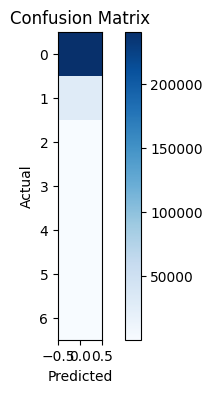

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

pdf = predictions.select("label", "prediction").toPandas()

confusion = pd.crosstab(pdf["label"], pdf["prediction"], rownames=["Actual"], colnames=["Predicted"])

plt.figure(figsize=(6,4))
plt.imshow(confusion, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Scaling for Big Data

In [20]:
train_df.cache()
test_df.cache()


DataFrame[job_link: string, last_processed_time: string, got_summary: string, got_ner: string, is_being_worked: string, job_title: string, company: string, job_location: string, first_seen: string, search_city: string, search_country: string, search_position: string, job_level: string, job_type: string, job_title_index: double, company_index: double, location_index: double, label: double, features: vector]

DISTRIBUTION OF JOB TITLES

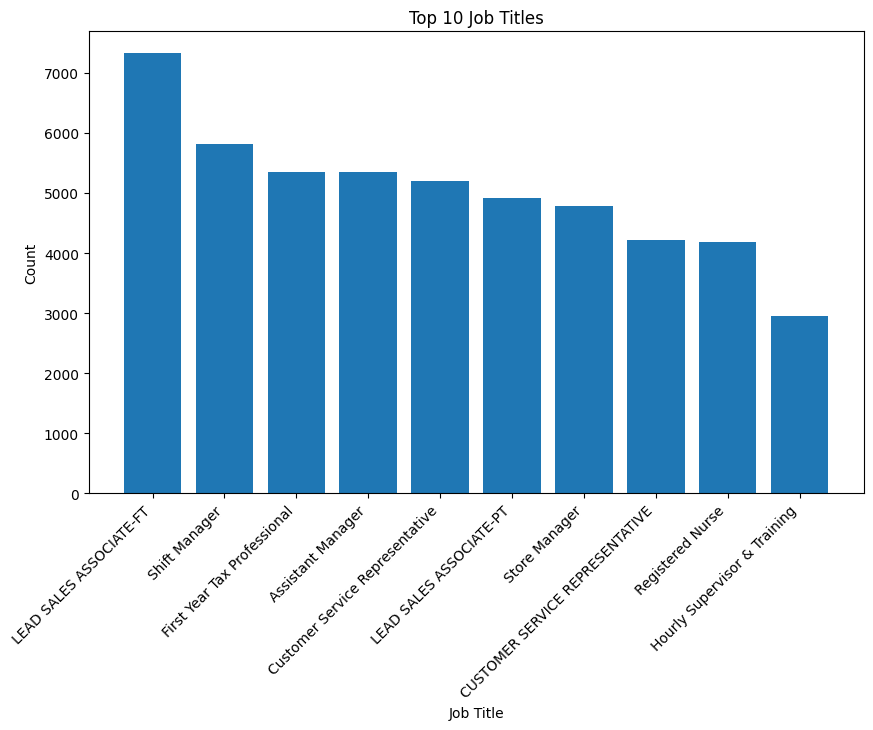

In [21]:
# Count top job titles
job_counts = df.groupBy("job_title").count().orderBy("count", ascending=False).limit(10)
job_counts_pd = job_counts.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(job_counts_pd["job_title"], job_counts_pd["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Job Titles")
plt.xlabel("Job Title")
plt.ylabel("Count")
plt.show()


LOCATION BAR CHART

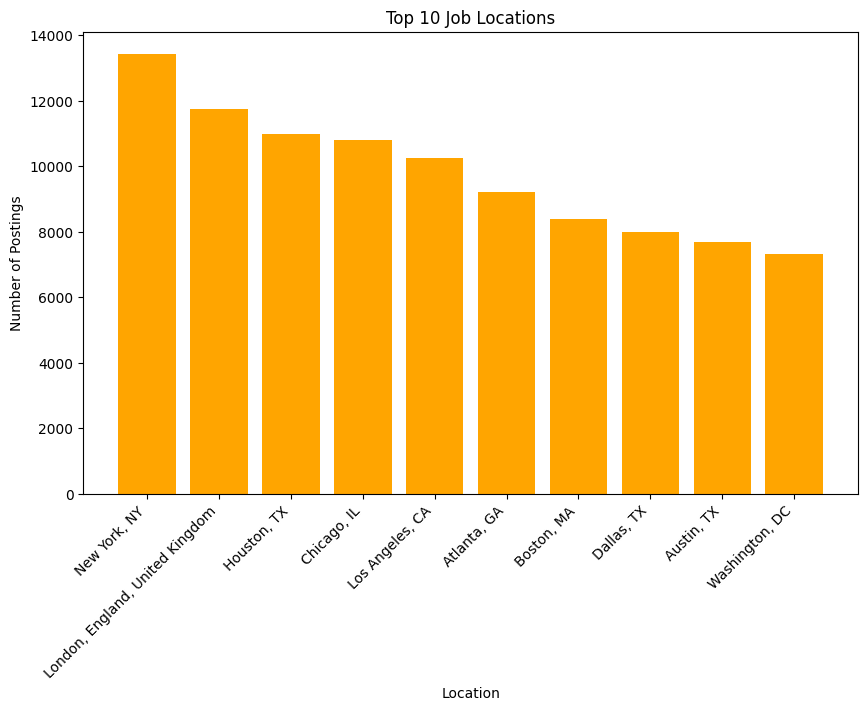

In [25]:
location_counts = df.groupBy("job_location").count().orderBy("count", ascending=False).limit(10)
location_counts_pd = location_counts.toPandas()

plt.figure(figsize=(10,6))
plt.bar(location_counts_pd["job_location"], location_counts_pd["count"], color="orange")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Job Locations")
plt.xlabel("Location")
plt.ylabel("Number of Postings")
plt.show()

STOP SPARK

In [36]:
spark.stop()
print("Spark session stopped.")

Spark session stopped.
